[Pima indians diabetes database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

# EDA

In [1]:
# imports for data imputation
import random
import arviz as az
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.optimize
import pytensor.tensor as pt
from pathlib import Path
from matplotlib.lines import Line2D
from pymc.sampling.jax import sample_blackjax_nuts, sample_numpyro_nuts
from scipy.stats import multivariate_normal
from sklearn.preprocessing import MinMaxScaler


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
s:\anaconda\envs\bart\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("./diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Outcome is a discrete variable with 0 for no diabetes and 1 for diabetes


Pregnancies is a discrete variable with the counts of Pregnancies


Glucose is a continuous variable


Insulin is a continuous variable


Blood pressure is a continuous variable


Skin thickness is a continuous variable


Insulin is a continuous variable


BMI is a continuous variable


DiabetesPedigreeFunction is a continuous variable


Age is a continuous variable although the values given are rounded to whole numbers


For better inference we need to normalise our variables


Feature selection notes


Study findings showed that skin thickness decreased as a result of type 2diabetic progression. Skin thickness was significantly influenced by insulin level, but not glucose level.


Type 1 diabetics with high blood sugar (glucose) levels can have a high skin thickness instead.


Since we don't have details regarding whether the patients suffer from Type1 or Type2 diabetes we can not infer much from this variable and it is best to drop it.\\


In [3]:
# Define the outcome and predictors
bmi = df["BMI"]
age = df["Age"]
glucose = df["Glucose"]
insulin = df["Insulin"]
dpf = df["DiabetesPedigreeFunction"]
bp = df["BloodPressure"]
preg = df["Pregnancies"]
outcome = df["Outcome"]

In [4]:
bmi.describe()

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

In [5]:
age.describe()

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64

In [6]:
glucose.describe()

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

In [7]:
insulin.describe()

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64

In [8]:
dpf.describe()

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64

In [9]:
bp.describe()

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

In [10]:
preg.describe()

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64

In [11]:
outcome.describe()

count    768.000000
mean       0.348958
std        0.476951
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Outcome, dtype: float64

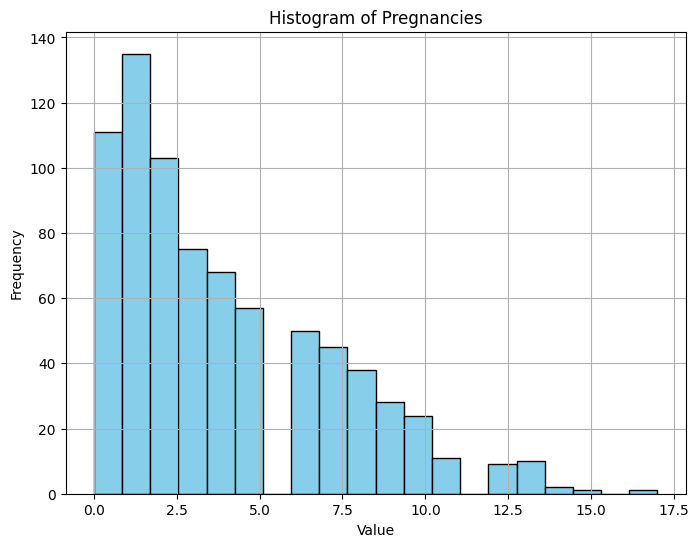

In [12]:
# Plotting the histograms
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(preg, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Pregnancies')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like a right skewed truncated normal distribution. Truncate at zero.

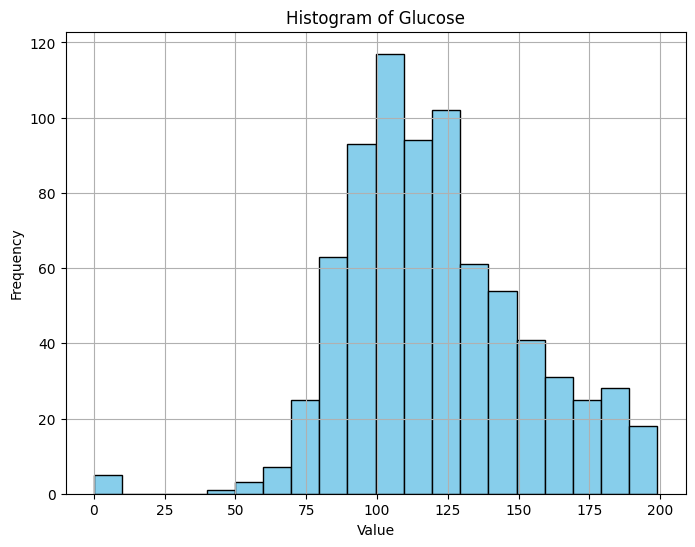

In [13]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(glucose, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Glucose')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()


looks like left skewed normal. missing values are zero but there shouldn't be any that low humanly possible.

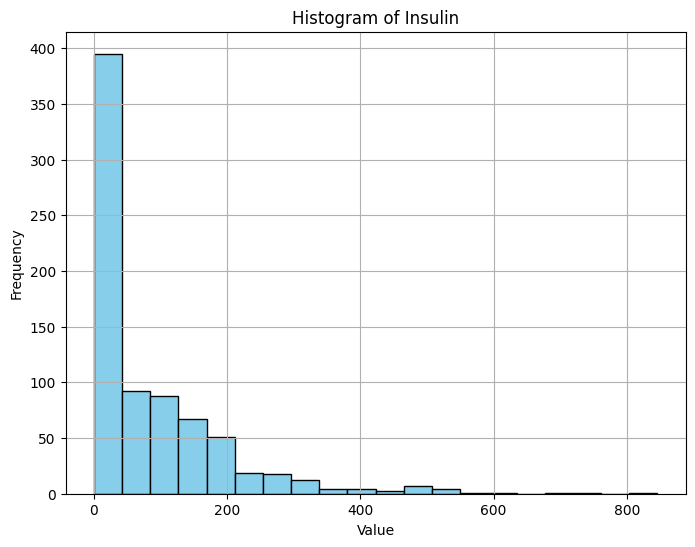

In [14]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(insulin, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Insulin')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like right skewed normal. note that there are zero values which should be imputed making it look like a heavier tail

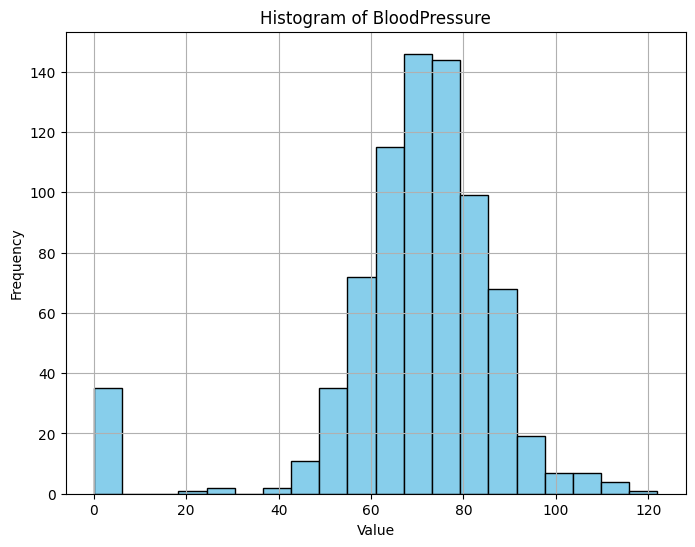

In [15]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(bp, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of BloodPressure')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like location shifted normal, values at zero represent missing values

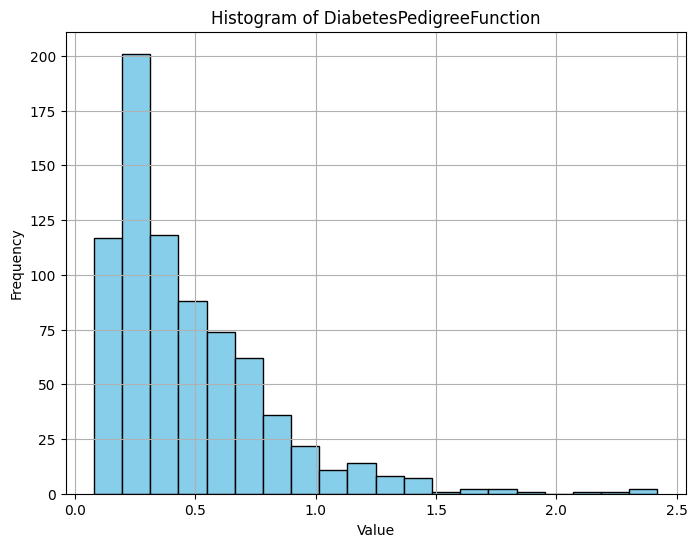

In [16]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(dpf, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of DiabetesPedigreeFunction')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

zero trunc right skewed normal

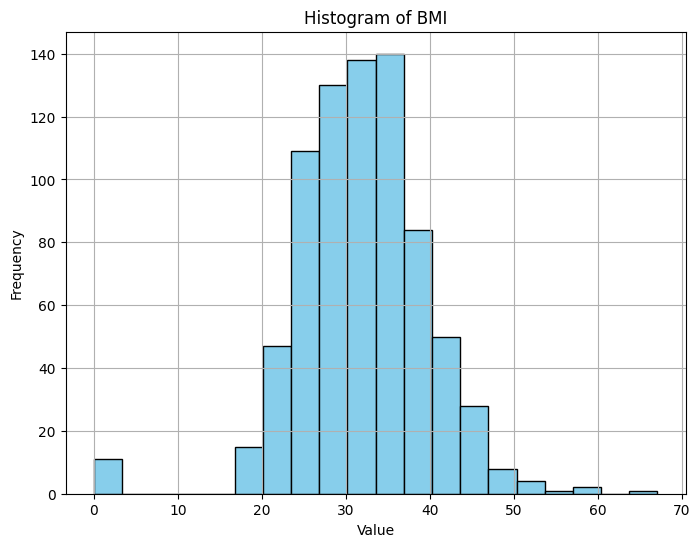

In [17]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(bmi, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of BMI')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like location shifted normal. zero values are supposed to be missing values.

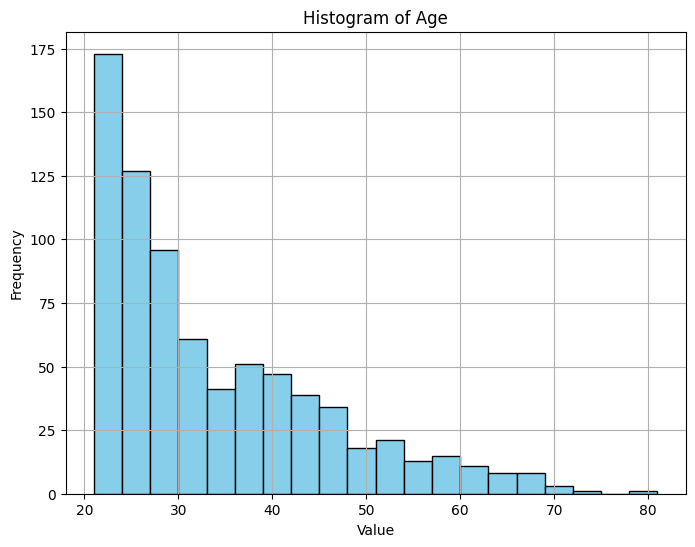

In [18]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(age, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Age')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

looks like right skewed normal truncated at 21

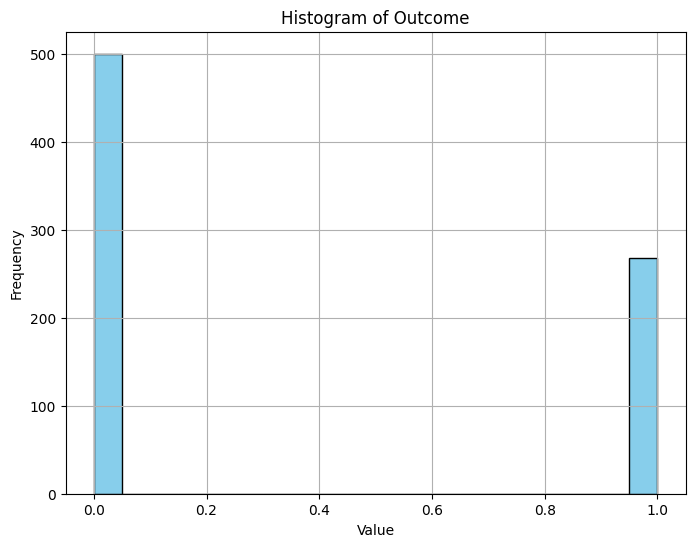

In [19]:
import math
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(outcome, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Outcome')  # Add a title
plt.xlabel('Value')  # Add a label for the x-axis
plt.ylabel('Frequency')  # Add a label for the y-axis
plt.grid(True)  # Add grid lines
plt.show()

bernoulli outcome

# DATA IMPUTATION
We used MICE algorithm for data imputation which is a frequentist technique because we didn't want to introduce more subjectivity in our model and we were unsure how it would affect the BART modelling process. MICE makes fewer assumptions about the underlying distribution for imputing data. If we had strongly informative priors which were inaccurate then it would reduce BART model significantly. It is important to note that there is an underlying assumption that the missing data is Missing Completely At Random or Missing At Random instead of Missing Not At Random which can only be modelled and imputed properly via bayesian methods.

In [20]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

x = np.array([age, preg, dpf, glucose, insulin, bmi, bp])
x

array([[ 50.   ,  31.   ,  32.   , ...,  30.   ,  47.   ,  23.   ],
       [  6.   ,   1.   ,   8.   , ...,   5.   ,   1.   ,   1.   ],
       [  0.627,   0.351,   0.672, ...,   0.245,   0.349,   0.315],
       ...,
       [  0.   ,   0.   ,   0.   , ..., 112.   ,   0.   ,   0.   ],
       [ 33.6  ,  26.6  ,  23.3  , ...,  26.2  ,  30.1  ,  30.4  ],
       [ 72.   ,  66.   ,  64.   , ...,  72.   ,  60.   ,  70.   ]])

In [21]:
outcome = np.array(outcome)
type(outcome)

numpy.ndarray

In [22]:
# missing_cols = {"Glucose":3, "BloodPressure":5, "Insulin":4, "BMI":6}
value_to_replace = 0
mask = np.zeros(shape=(x.shape[0], x.shape[1]), dtype=bool)
print(x.shape)
for col in range(3,7):
    for i in range(len(x[0])):
        if x[col][i] == value_to_replace:
            x[col][i] = np.nan
            mask[col][i] = True
df = pd.DataFrame(x.T, columns=["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure"])
df.head()

(7, 768)


,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure
0,50.0,6.0,0.627,148.0,NaN,33.6,72.0
1,31.0,1.0,0.351,85.0,NaN,26.6,66.0
2,32.0,8.0,0.672,183.0,NaN,23.3,64.0
3,21.0,1.0,0.167,89.0,94.0,28.1,66.0
4,33.0,0.0,2.288,137.0,168.0,43.1,40.0


In [23]:
df.describe()

,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure
count,768.000000,768.000000,768.000000,763.000000,394.000000,757.000000,733.000000
mean,33.240885,3.845052,0.471876,121.686763,155.548223,32.457464,72.405184
std,11.760232,3.369578,0.331329,30.535641,118.775855,6.924988,12.382158
min,21.000000,0.000000,0.078000,44.000000,14.000000,18.200000,24.000000
25%,24.000000,1.000000,0.243750,99.000000,76.250000,27.500000,64.000000
50%,29.000000,3.000000,0.372500,117.000000,125.000000,32.300000,72.000000
75%,41.000000,6.000000,0.626250,141.000000,190.000000,36.600000,80.000000
max,81.000000,17.000000,2.420000,199.000000,846.000000,67.100000,122.000000


In [24]:
imputer = IterativeImputer(max_iter=5, random_state=0, skip_complete=True, sample_posterior=True, verbose=2) # number of iterations for MICE algorithm and seed value for reproducibility
imputed_values = imputer.fit_transform(x)
imputed_values

[IterativeImputer] Completing matrix with shape (7, 768)


[IterativeImputer] Ending imputation round 1/5, elapsed time 3.67
[IterativeImputer] Ending imputation round 2/5, elapsed time 7.19
[IterativeImputer] Ending imputation round 3/5, elapsed time 10.65
[IterativeImputer] Ending imputation round 4/5, elapsed time 14.08
[IterativeImputer] Ending imputation round 5/5, elapsed time 18.19


array([[5.00000000e+01, 3.10000000e+01, 3.20000000e+01, ...,
        3.00000000e+01, 4.70000000e+01, 2.30000000e+01],
       [6.00000000e+00, 1.00000000e+00, 8.00000000e+00, ...,
        5.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [6.27000000e-01, 3.51000000e-01, 6.72000000e-01, ...,
        2.45000000e-01, 3.49000000e-01, 3.15000000e-01],
       ...,
       [2.08995986e+02, 8.93920734e+01, 2.74087978e+02, ...,
        1.12000000e+02, 1.86448974e+02, 9.91161305e+01],
       [3.36000000e+01, 2.66000000e+01, 2.33000000e+01, ...,
        2.62000000e+01, 3.01000000e+01, 3.04000000e+01],
       [7.20000000e+01, 6.60000000e+01, 6.40000000e+01, ...,
        7.20000000e+01, 6.00000000e+01, 7.00000000e+01]])

In [25]:
x[mask] = imputed_values[mask]
df = pd.DataFrame(x.T, columns=["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure"])

In [26]:
df.describe()

,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,33.240885,3.845052,0.471876,121.619741,152.223695,32.385355,72.151062
std,11.760232,3.369578,0.331329,30.500880,93.974674,6.937736,12.510370
min,21.000000,0.000000,0.078000,44.000000,12.654739,18.200000,24.000000
25%,24.000000,1.000000,0.243750,99.000000,94.634263,27.400000,64.000000
50%,29.000000,3.000000,0.372500,117.000000,135.000000,32.150000,72.000000
75%,41.000000,6.000000,0.626250,141.000000,185.261750,36.600000,80.000000
max,81.000000,17.000000,2.420000,199.000000,846.000000,67.100000,122.000000


## Normalizing data for faster convergence and better results


In [27]:
# normalizing all continuous variables
scaler = MinMaxScaler()
x = x.T
# Fit and transform only those columns
x_scaled = scaler.fit_transform(x)

In [28]:
first_two_features = x[:, :2]  # First two features (columns)
remaining_features_scaled = x_scaled[:, 2:]  # Features (columns) from index 2 onwards in x_scaled
x_cont_var_normalized = np.concatenate([first_two_features.T, remaining_features_scaled.T], axis=0)

In [29]:
df = pd.DataFrame(x_cont_var_normalized.T, columns=["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure"])
df["Glucose_Insulin_Product"] = df["Glucose"] * df["Insulin"] # adding an interaction term as these quantities are highly correlated
df.describe()

,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure,Glucose_Insulin_Product
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,33.240885,3.845052,0.168179,0.500773,0.167480,0.290089,0.491337,0.098513
std,11.760232,3.369578,0.141473,0.196780,0.112768,0.141876,0.127657,0.101151
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,1.000000,0.070773,0.354839,0.098374,0.188139,0.408163,0.034250
50%,29.000000,3.000000,0.125747,0.470968,0.146812,0.285276,0.489796,0.069304
75%,41.000000,6.000000,0.234095,0.625806,0.207125,0.376278,0.571429,0.123662
max,81.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.935484


# BART model

In [30]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = "retina"

print(f"Running on PyMC v{pm.__version__}")

RANDOM_SEED = 5781
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Running on PyMC v5.12.0


In [31]:

df2 = pd.DataFrame(outcome, columns=["Outcome"])
X = df.to_numpy()
Y = df2.to_numpy()
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

In [32]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)
print(Y_train.shape, Y_test.shape)

(614, 8) (614, 1) (154, 8) (154, 1)
(614,) (154,)


In [33]:
with pm.Model() as diabetes_model:
    # BART model for predicted probability of diabetes
    x_data = pm.MutableData("x_train", X_train)
    y_data = Y_train
    μ = pmb.BART("μ", X=x_data, Y=y_data, m=50)   # m is number of subtrees. 50, 100 and 200 are common in practice
    # Define Bernoulli likelihood for the outcome
    p = pm.Deterministic("p", pm.math.sigmoid(μ))  # Map logit to probability (0-1)
    diabetes = pm.Bernoulli("diabetes", p=p, observed=y_data, shape=(x_data.shape[0],))
    idata_oos_regression = pm.sample(random_seed=RANDOM_SEED, draws=4000, tune=2000, chains=4)
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 650 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [diabetes]


# Convergence diagnostics

array([<Axes: xlabel='ESS'>, <Axes: xlabel='R-hat'>], dtype=object)

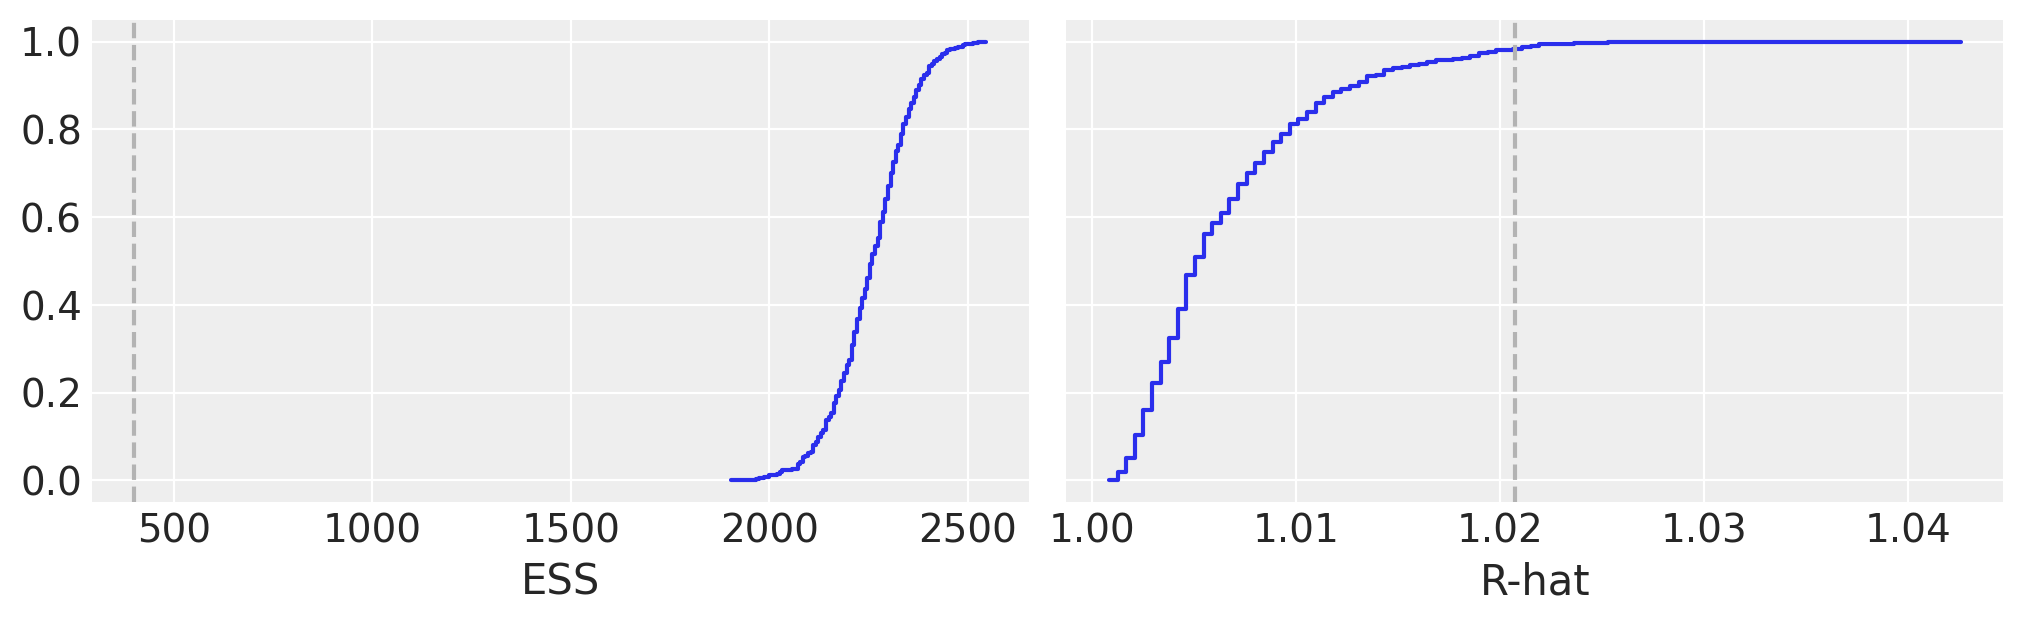

In [34]:
pmb.plot_convergence(idata_oos_regression, var_name="μ")

We have two panels one for ESS and one for the R-hat. 
The blue line is the empirical cumulative distribution for those values, for the ESS we want the curve to be on the right of the dashed line, and for R-hat we want the curve to be on the left the dashed line. 
In the above figure, we can see that we satisfy it for most of the curves.


Although, in the BART literature, the diagnostics of the BART variables is sometimes considered less important than the diagnostics of the non-BART variables, the main argument is that the individual estimates of the latent variables are of no direct interest, and instead we should only care about how well we are estimating the whole function/regression.

# Partial dependence plots
To help us interpret the results of our model we are going to use partial dependence plots. This is a type of plot that shows the marginal effect that one covariate has on the predicted variable. That is, what is the effect that a covariate $X_i$ has of $Y$ while we average over all the other covariates ( $X_j$ for all $j \neq i$).

array([<Axes: xlabel='X_0'>, <Axes: xlabel='X_1'>, <Axes: xlabel='X_2'>,
       <Axes: xlabel='X_3'>, <Axes: xlabel='X_4'>, <Axes: xlabel='X_5'>,
       <Axes: xlabel='X_6'>, <Axes: xlabel='X_7'>], dtype=object)

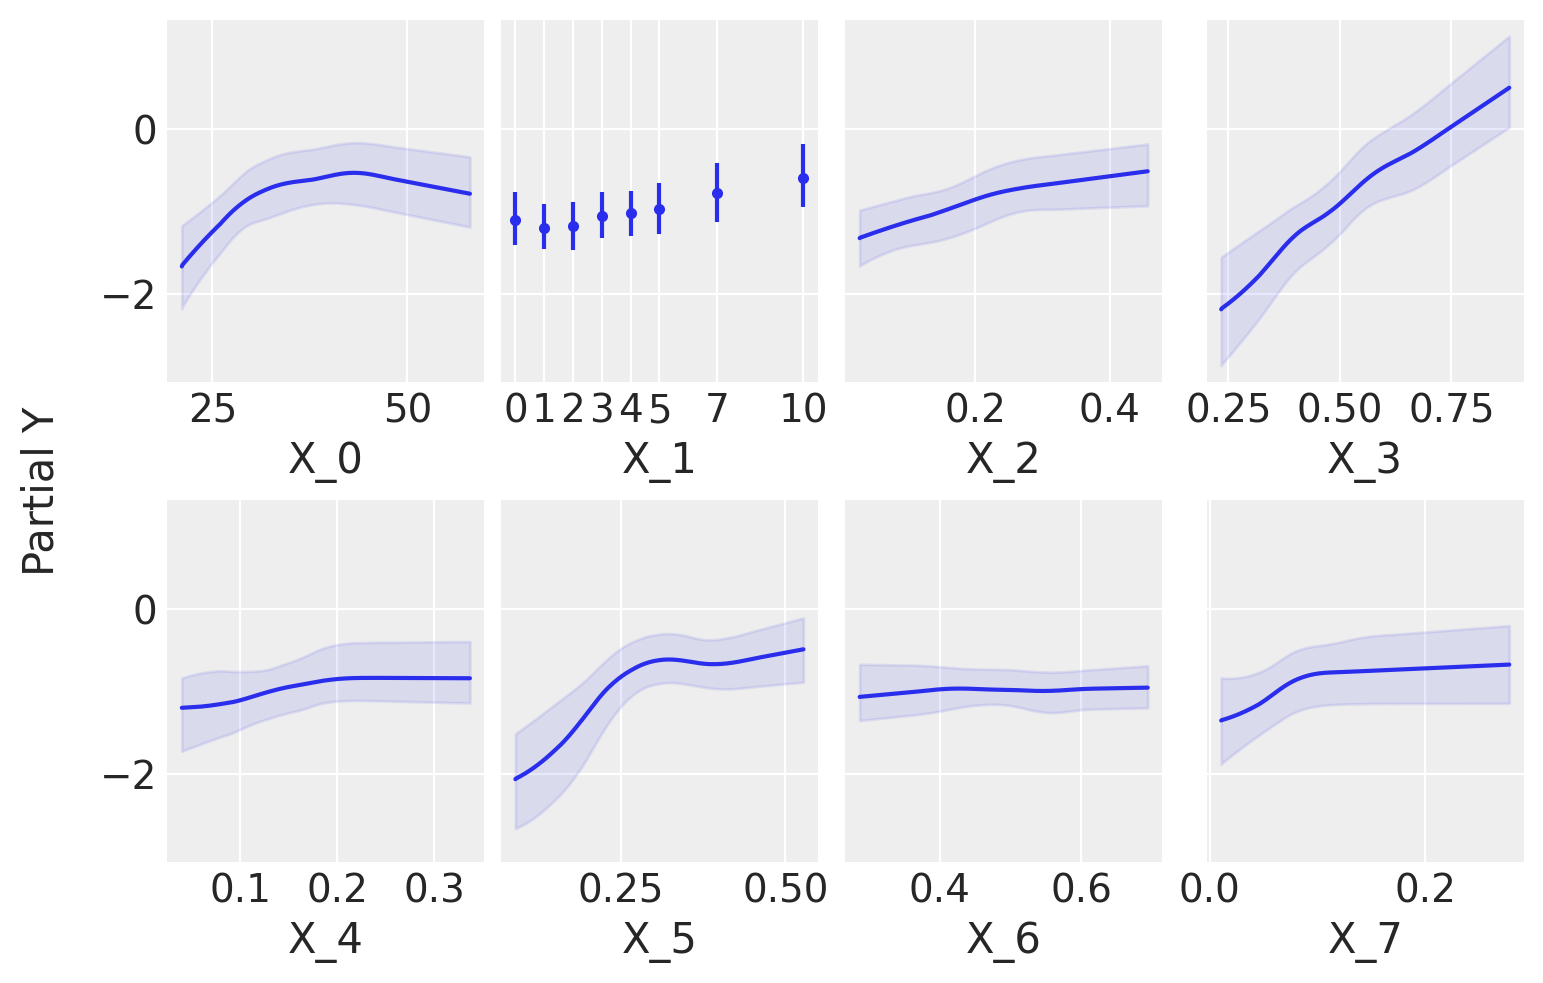

In [35]:
pmb.plot_pdp(μ, X=x_data, Y=y_data, grid=(2, 4), var_discrete=[1])

# Variable importance

The ranking of the variables is computed with a simple heuristic. We just count how many times a variable is included in all the regression trees. The intuition is that if a variable is important it should appear more often in the fitted trees than less important variables.

([3, 5, 0, 2, 7, 1, 4, 6], <Axes: ylabel='R²'>)

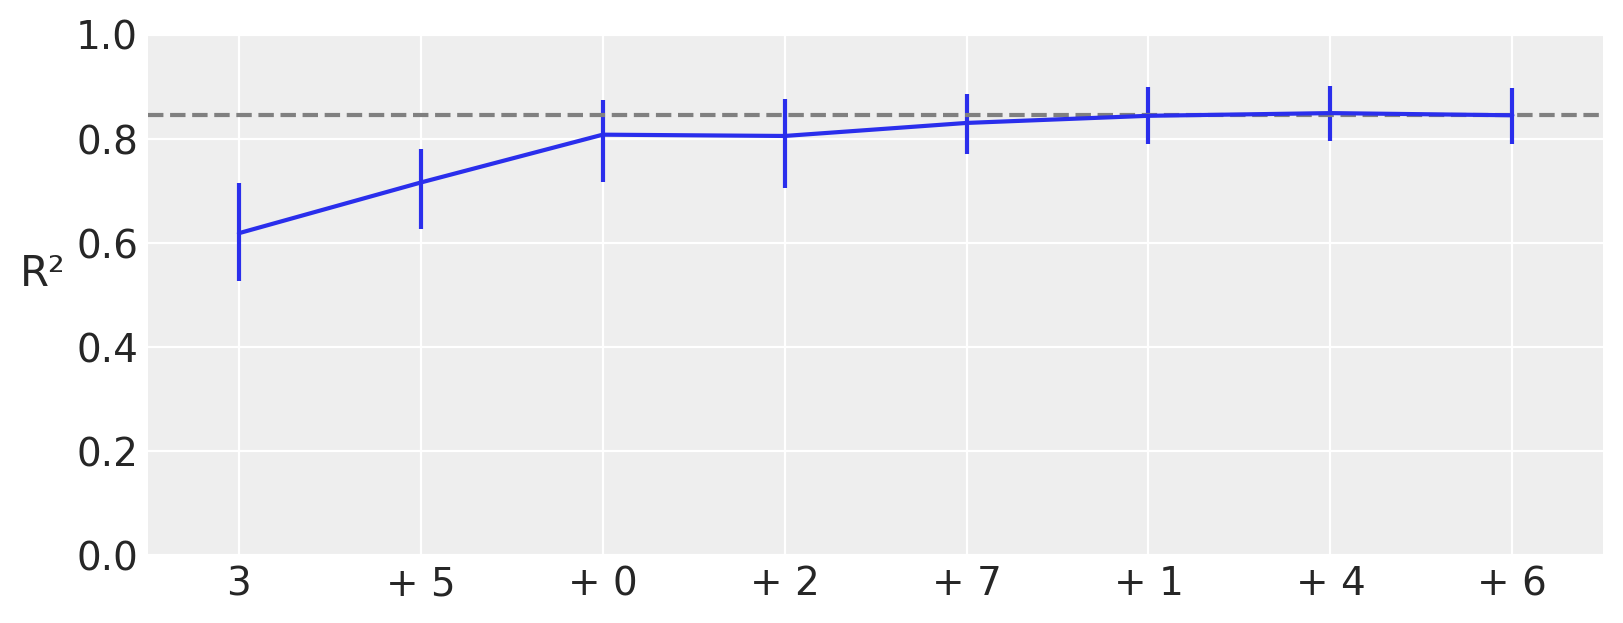

In [36]:
pmb.plot_variable_importance(idata_oos_regression, μ, X_train)

Age:0,	
Pregnancies:1,
DiabetesPedigreeFunction:2,
Glucose:3,
Insulin:4,
BMI:5,
BloodPressure:6,
Glucose_Insulin_Product:7


On the x-axis we have the number of covariables and on the y-axis R² (the the square of the Pearson correlation coefficient) between the predictions made for the full model (all variables included) and the restricted models, those with only a subset of the variables.

The most important variable is Glucose, then BMI, Age, Glucose_Insulin_Product, DiabetesPedigreeFunction, Pregnancies, Insulin and finally BloodPressure. 
The first value of R², is the value of a model that only includes the variable Glucose, the second R² is for a model with two variables, Glucose and BMI, and so on. 

Besides this ranking, we can see that even a model with five components Glucose, BMI, Age, Glucose_Insulin_Product, DiabetesPedigreeFunction is on average indistinguishable from the full model. The error bars represent the 94 % HDI from the posterior predictive distribution.

This means that we should expect a model with only Glucose, BMI, Age, Glucose_Insulin_Product, DiabetesPedigreeFunction to have a similar predictice performance than a model with all the variables.

# Out-of-Sample Predictions

In [44]:
with diabetes_model:
    x_data.set_value(X_test)
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

Sampling: [diabetes, μ]


[Text(0.5, 1.0, 'Posterior Predictive Check (test)')]

s:\anaconda\envs\bart\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
s:\anaconda\envs\bart\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


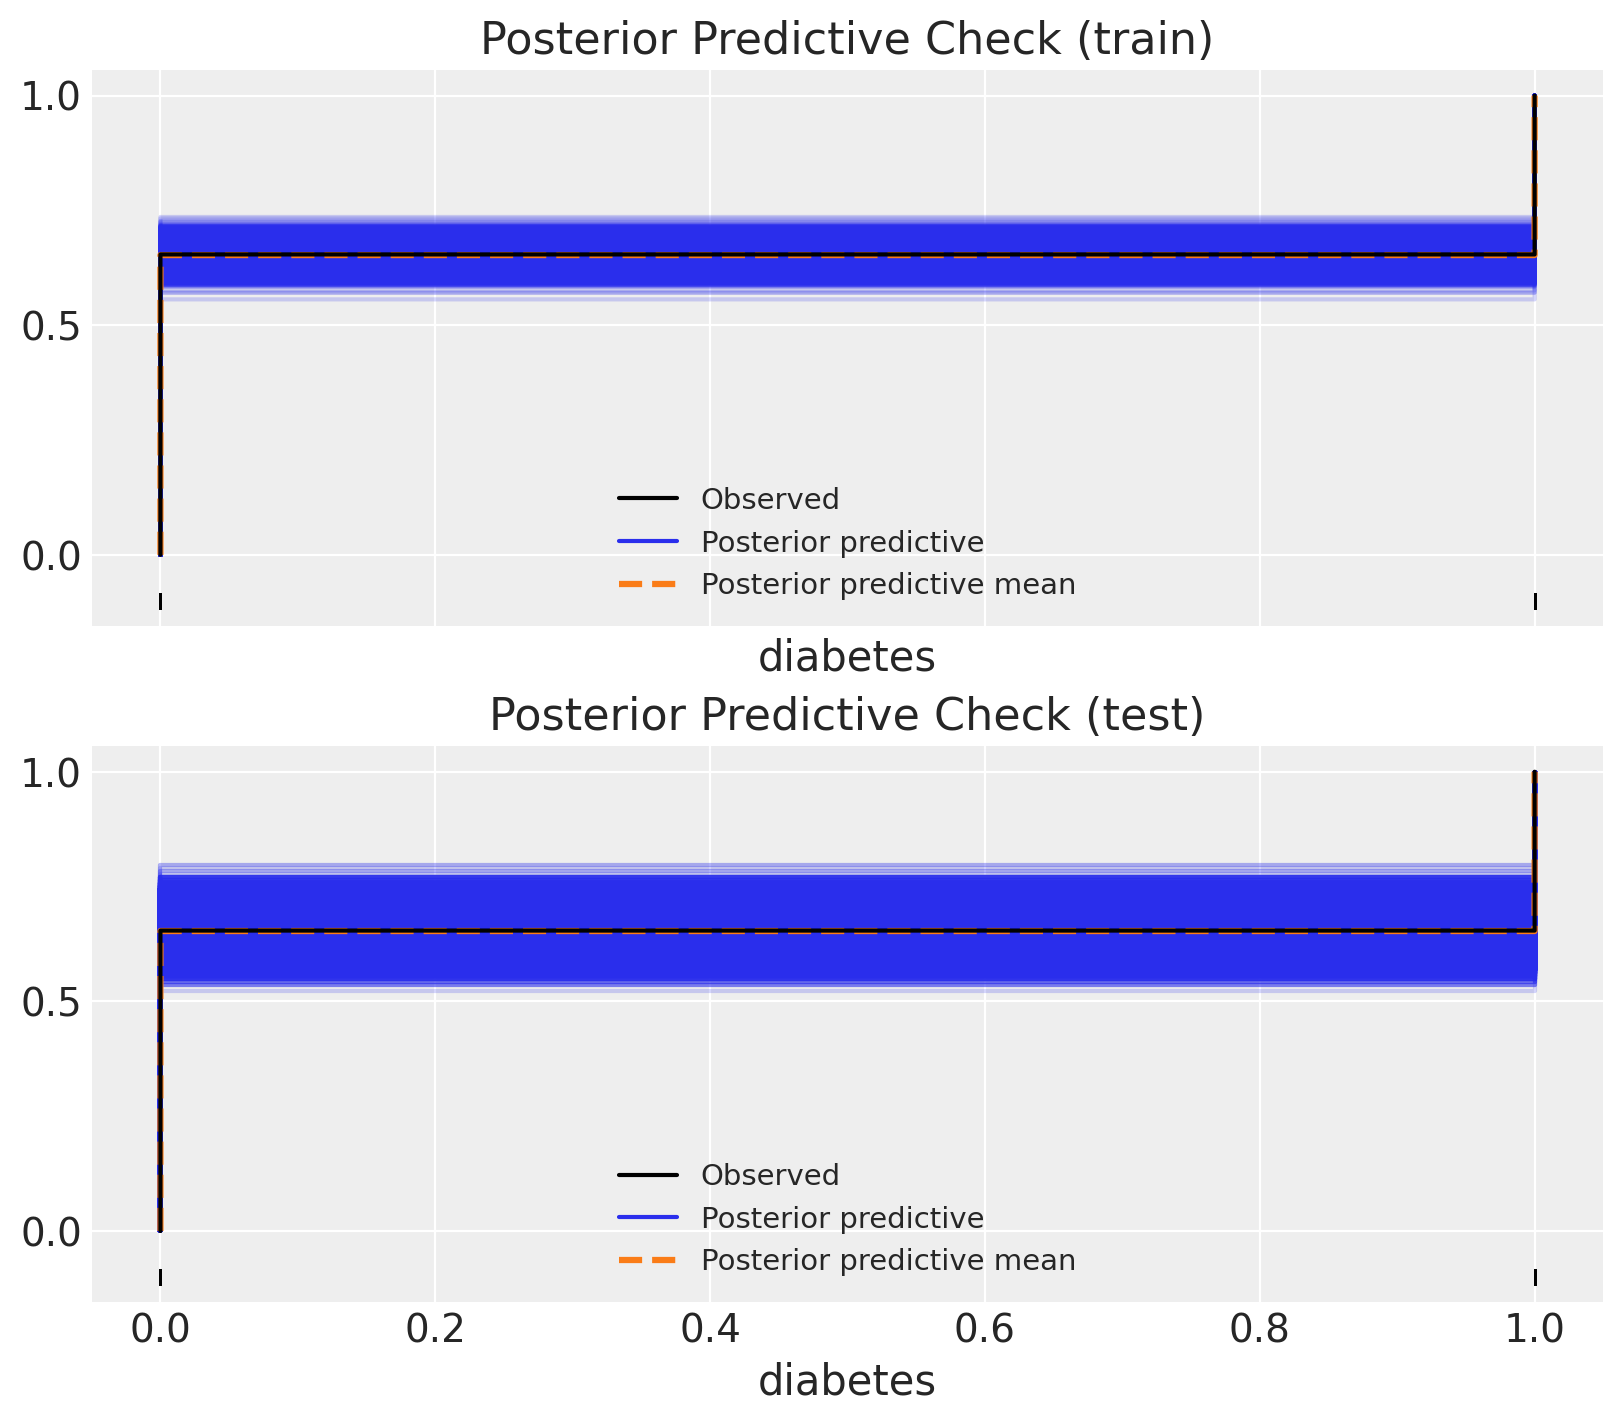

In [45]:
import arviz

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 7), sharex=True, sharey=True, layout="constrained"
)

az.plot_ppc(
    data=posterior_predictive_oos_regression_train, kind="cumulative", observed_rug=True, ax=ax[0]
)
ax[0].set(title="Posterior Predictive Check (train)")

az.plot_ppc(
    data=posterior_predictive_oos_regression_test, kind="cumulative", observed_rug=True, ax=ax[1]
)
ax[1].set(title="Posterior Predictive Check (test)")

# Comparison with a baseline model

In [48]:
df3 = pd.DataFrame(X_train, columns=["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure", "Glucose_Insulin_Product"])
df3.describe() 

,Age,Pregnancies,DiabetesPedigreeFunction,Glucose,Insulin,BMI,BloodPressure,Glucose_Insulin_Product
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,33.434853,3.889251,0.169497,0.497625,0.164956,0.292607,0.490115,0.096592
std,11.815941,3.387548,0.145700,0.194787,0.109801,0.137821,0.128259,0.100356
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.004090,0.000000,0.000000
25%,24.000000,1.000000,0.068851,0.354839,0.098192,0.191412,0.408163,0.034660
50%,29.000000,3.000000,0.127028,0.470968,0.146812,0.290389,0.489796,0.068445
75%,41.000000,6.000000,0.234308,0.617742,0.203211,0.374233,0.571429,0.119320
max,81.000000,17.000000,1.000000,0.993548,1.000000,1.000000,1.000000,0.935484


In [49]:
df3.mean()

Age                         33.434853
Pregnancies                  3.889251
DiabetesPedigreeFunction     0.169497
Glucose                      0.497625
Insulin                      0.164956
BMI                          0.292607
BloodPressure                0.490115
Glucose_Insulin_Product      0.096592
dtype: float64

In [61]:
features = ["Age", "Pregnancies", "DiabetesPedigreeFunction", "Glucose", "Insulin", "BMI", "BloodPressure", "Glucose_Insulin_Product"]

with pm.Model() as baseline_model:
    x_data1 = pm.MutableData("x_data1", X_train)
    y_data1 = pm.Data("y_data1", Y_train)
    betas = pm.Normal('betas', mu=np.zeros(8), sigma=np.ones(8))
    mu = pm.math.dot(x_data1, betas)
    p = pm.Deterministic("p", pm.math.invprobit(mu))
    likelihood = pm.Bernoulli("likelihood", p=p, observed=Y, shape=(x_data1.shape[0],))
    idata_oos_regression = pm.sample(4000, tune=2000, chains=4, random_seed=RANDOM_SEED)
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

s:\anaconda\envs\bart\Lib\site-packages\pymc\data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 108 seconds.
Sampling: [likelihood]


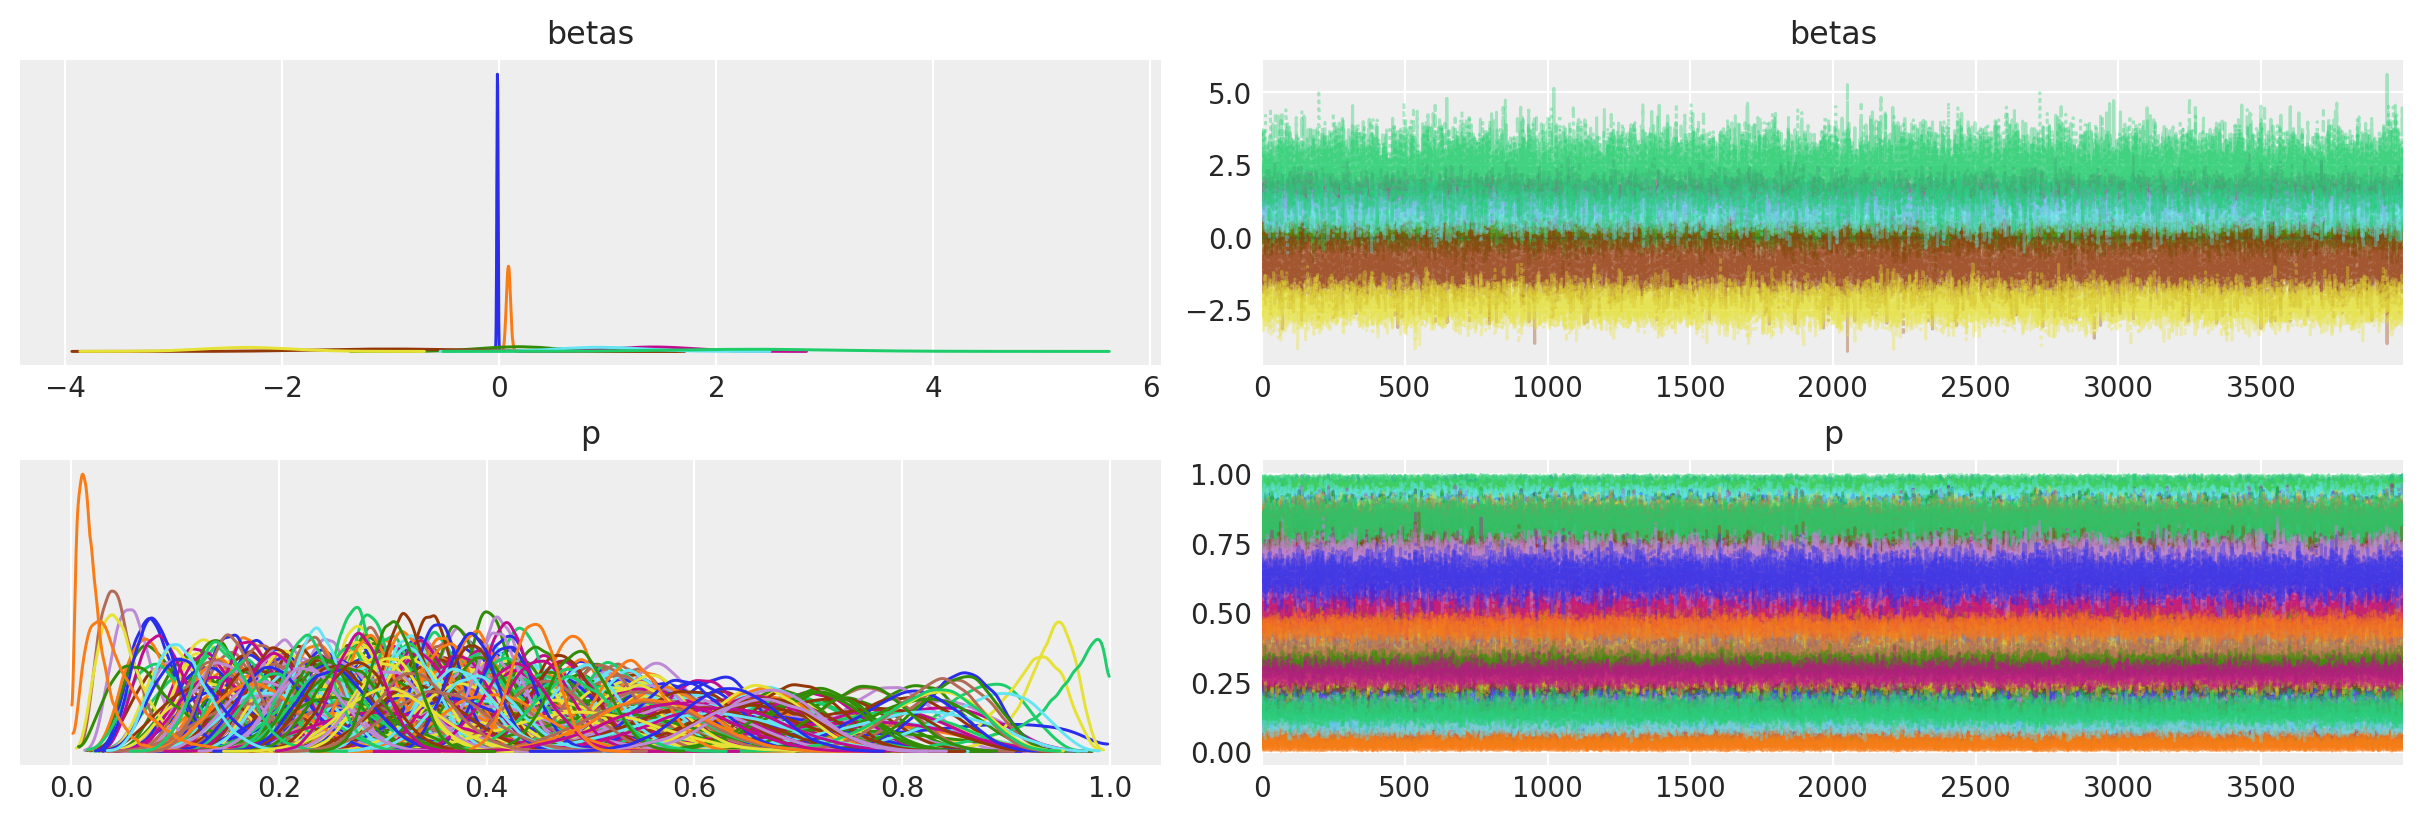

In [62]:
import arviz as az
with baseline_model:
    az.plot_trace(idata_oos_regression, combined=True)

In [63]:
with baseline_model:
    print(az.summary(idata_oos_regression))

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0] -0.017  0.006  -0.028   -0.006      0.000    0.000   10762.0   
betas[1]  0.085  0.019   0.049    0.120      0.000    0.000   12953.0   
betas[2]  0.162  0.349  -0.490    0.825      0.003    0.003   16865.0   
betas[3]  1.422  0.369   0.710    2.095      0.003    0.002   12338.0   
betas[4] -0.989  0.677  -2.269    0.253      0.006    0.005   11741.0   
...         ...    ...     ...      ...        ...      ...       ...   
p[609]    0.331  0.036   0.264    0.400      0.000    0.000   18262.0   
p[610]    0.632  0.045   0.545    0.712      0.000    0.000   14862.0   
p[611]    0.446  0.022   0.405    0.486      0.000    0.000   13593.0   
p[612]    0.311  0.022   0.271    0.351      0.000    0.000   14435.0   
p[613]    0.277  0.024   0.231    0.324      0.000    0.000   13439.0   

          ess_tail  r_hat  
betas[0]   10806.0    1.0  
betas[1]   11445.0    1.0  
betas[2]   12068.0    1.0  
betas[3]   

In [64]:
with baseline_model:
    X.set_value(X_test)
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

Sampling: [likelihood]


s:\anaconda\envs\bart\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


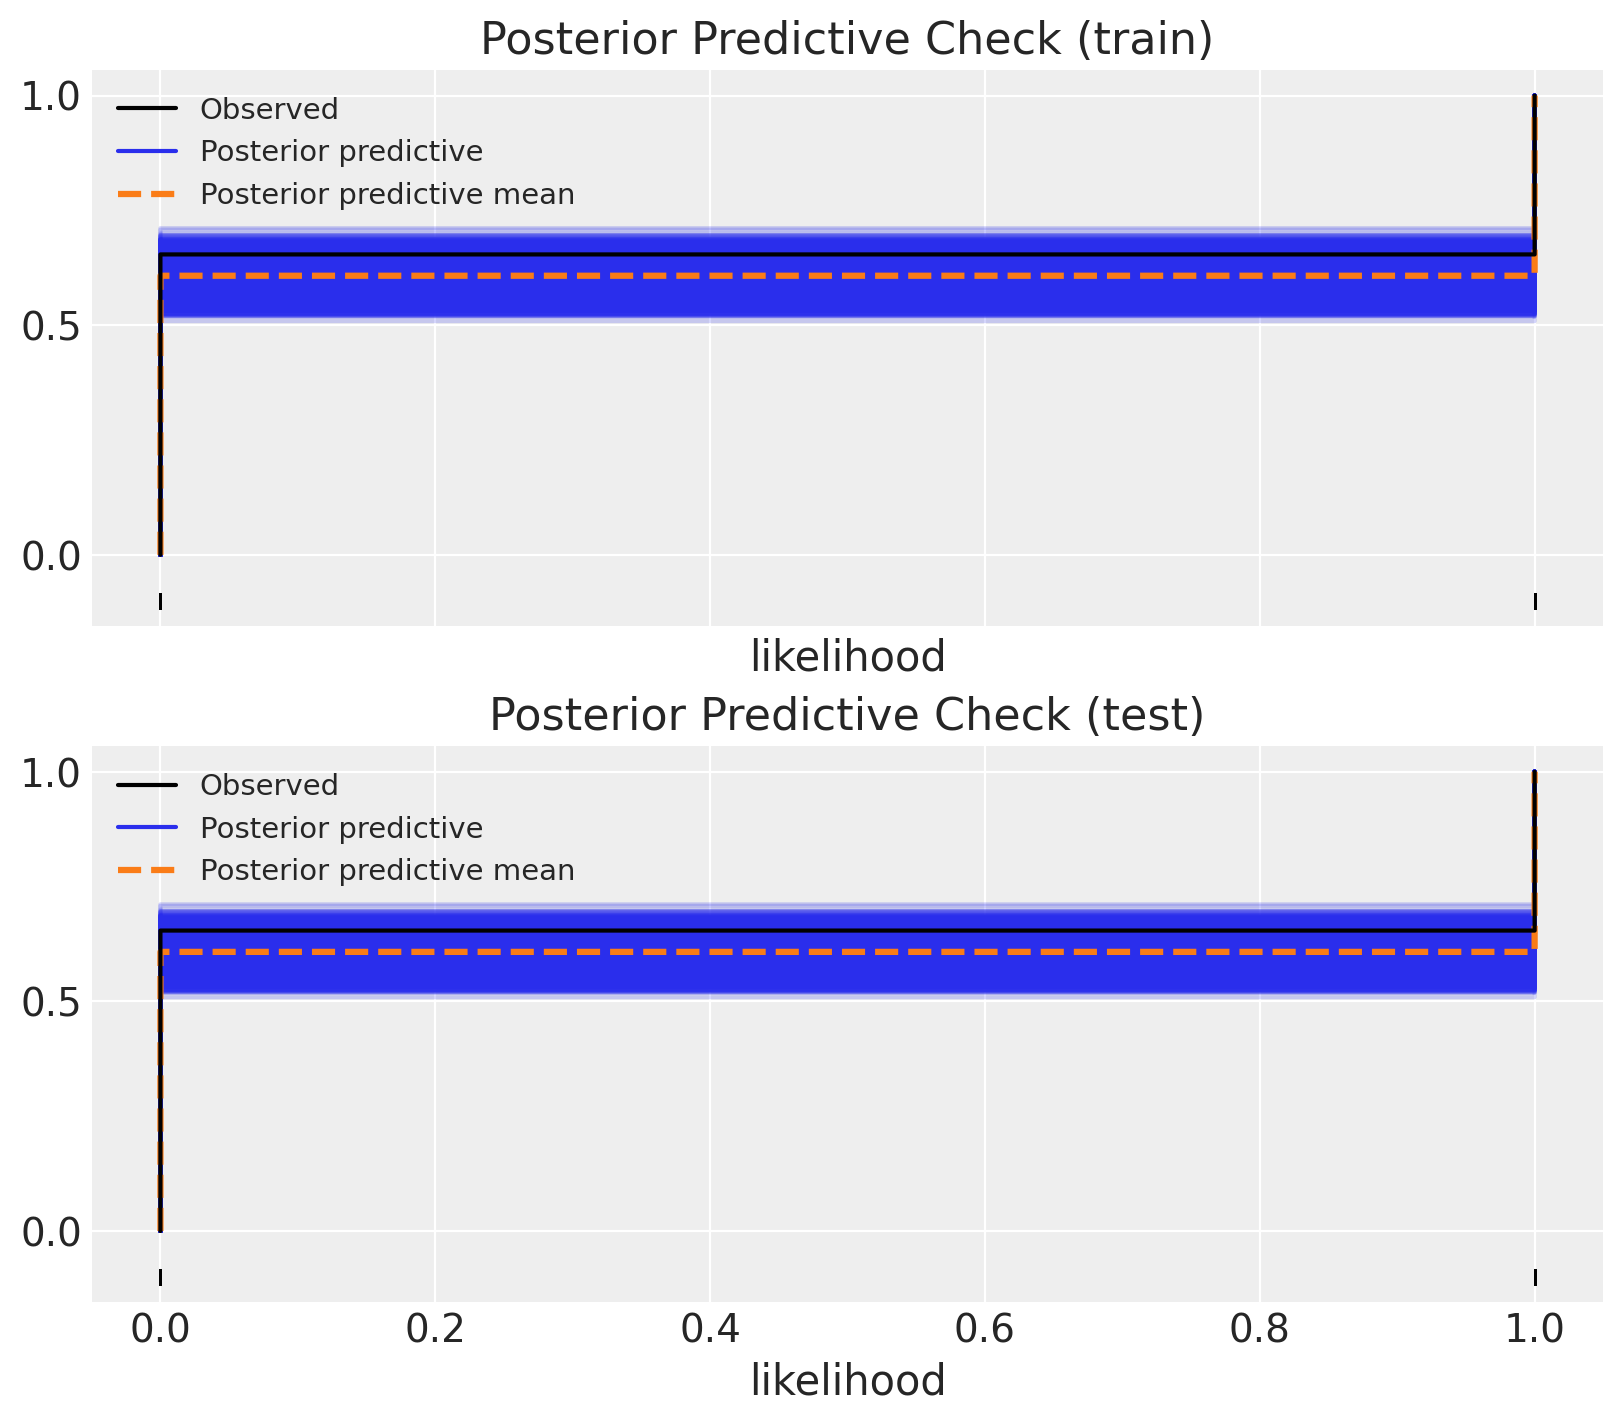

In [65]:
with baseline_model:
    
    fig, ax = plt.subplots(
        nrows=2, ncols=1, figsize=(8, 7), sharex=True, sharey=True, layout="constrained"
    )

    az.plot_ppc(
        data=posterior_predictive_oos_regression_train, kind="cumulative", observed_rug=True, ax=ax[0]
    )
    ax[0].set(title="Posterior Predictive Check (train)")

    az.plot_ppc(
        data=posterior_predictive_oos_regression_test, kind="cumulative", observed_rug=True, ax=ax[1]
    )
    ax[1].set(title="Posterior Predictive Check (test)")